In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
from copy import deepcopy as dc
import tqdm

from particle_transformer.dataloader import read_file
from weaver.train import train_load, test_load, model_setup, optim
from weaver.utils.data.fileio import _read_parquet
from weaver.utils.nn.tools import _flatten_preds, _logger, Counter

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
def mkdir(save_dir):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    return save_dir

def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [3]:
model_path = './top_landscape/models/'
data_path = "./top_landscape/data/"

data_config = "./top_landscape/particle_transformer/data/TopLandscape/top_kin.yaml"
model_config = "./top_landscape/particle_transformer/networks/example_ParticleNet.py"

log_path = './top_landscape/logs/'

In [4]:
class empty():
    def __init__(self):
        pass

project = empty()
project.data_train = [data_path + '/train_file.parquet']
table = _read_parquet(project.data_train, {'label'})
project.len_data_train = len(table)
del table

project.data_val = [data_path + '/val_file.parquet']
project.data_test = [data_path + '/test_file.parquet']
project.data_config = data_config
project.network_config = model_config
project.num_workers = 1
project.fetch_step = 1
project.in_memory = True
project.batch_size = 512
project.samples_per_epoch = 2400*project.batch_size #2400
project.samples_per_epoch_val = 800*project.batch_size #800
project.num_epochs = 60
project.gpus = 0
project.start_lr = 1e-2
project.optimizer = "adam" 
project.log = log_path + '/ParticleNet_Test.log'
project.predict = False
project.predict_output = ''

project.regression_mode = False
project.extra_selection = None
project.extra_test_selection = None
project.data_fraction = 1
project.file_fraction = 1
project.fetch_by_files = False
project.train_val_split = 0.8
project.no_remake_weights = False
project.demo = False
project.lr_finder = None
project.tensorboard = None
project.tensorboard_custom_fn = None
project.network_option = []
project.load_model_weights = None
project.exclude_model_weights = None
project.steps_per_epoch = None
project.steps_per_epoch_val = None
project.optimizer_option = [('betas', '(0.99, 0.99)')]
project.lr_scheduler = "flat"#"flat+decay"
project.warmup_steps = 0
project.load_epoch = None
project.use_amp = False
project.predict_gpus = None
project.export_onnx = None
project.export_opset = 15
project.io_test = False
project.copy_inputs = False
project.print = False
project.profile = False
project.backend = None
project.cross_validation = None

project.local_rank = None if project.backend is None else int(os.environ.get("LOCAL_RANK", "0"))

project.model_prefix = mkdir(model_path + f'/ParticleNet_{project.optimizer}_lr{project.start_lr}_opt{project.optimizer_option}/')

if project.samples_per_epoch is not None:
    if project.steps_per_epoch is None:
        project.steps_per_epoch = project.samples_per_epoch // project.batch_size
    else:
        raise RuntimeError('Please use either `--steps-per-epoch` or `--samples-per-epoch`, but not both!')

if project.samples_per_epoch_val is not None:
    if project.steps_per_epoch_val is None:
        project.steps_per_epoch_val = project.samples_per_epoch_val // project.batch_size
    else:
        raise RuntimeError('Please use either `--steps-per-epoch-val` or `--samples-per-epoch-val`, but not both!')

if project.steps_per_epoch_val is None and project.steps_per_epoch is not None:
    project.steps_per_epoch_val = round(project.steps_per_epoch * (1 - project.train_val_split) / project.train_val_split)
if project.steps_per_epoch_val is not None and project.steps_per_epoch_val < 0:
    project.steps_per_epoch_val = None

if not "Acc" in os.listdir(project.model_prefix):
    mkdir(project.model_prefix+"Acc/")
if not "Loss" in os.listdir(project.model_prefix):
    mkdir(project.model_prefix+"Loss/")

In [5]:
train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(project)
model_MCMC, model_info_MCMC, loss_func_MCMC = model_setup(project, data_config, device=device)
model_MCMC = model_MCMC.to(device)
model_MCMC.device = device
model_MCMC.load_state_dict(torch.load('./models/base_model.pt'))

<All keys matched successfully>

# Test on OOD data from JetClass

In [6]:
data_OOD_path = "./JetClass/data/JetClass/train_100M/"
data_OOD_config = "./top_landscape/particle_transformer/data/JetClass/JetClass_kin.yaml"

project.data_config = data_OOD_config

In [7]:
def get_logits_and_labels_and_jetpt(model, project, test_loaders = None, data_config = None):
    if test_loaders is None or data_config is None:
        test_loaders, data_config = test_load(project)
    for _, get_test_loader in test_loaders.items():
        test_loader = get_test_loader()
        continue

    logits_list = []
    label_list = []
    jet_pT_list = []

    with torch.no_grad():
        with tqdm.tqdm(test_loader) as tq:
            for X, y, Z in tq:
                # X, y: torch.Tensor; Z: ak.Array
                inputs = [X[k].to(device) for k in data_config.input_names]
                label = y[data_config.label_names[0]].long().to(device)
                try:
                    mask = y[data_config.label_names[0] + '_mask'].bool().to(device)
                except KeyError:
                    mask = None
                model_output = model(*inputs)
                logits, label, mask = _flatten_preds(model_output, label=label, mask=mask)

                #_, preds = logits.max(1)

                logits_list.append(logits)
                label_list.append(label)
                jet_pT_list.append(Z['jet_pt'])

    logits = torch.cat(logits_list)
    label = torch.cat(label_list)
    jet_pt = torch.cat(jet_pT_list) 

    return logits, label, jet_pt, test_loaders, data_config

In [8]:
def calculate_preds_OOD(model, project, path_tmp, data_strs,  n_epochs = 50, n_samples = 10, stepsize=1):
    for data_str in data_strs:
        test_loaders, data_config = None, None
        if data_str in os.listdir(path_tmp):
            mutual_info = np.load(path_tmp + data_str + f'/mutual_info_{data_str}.npy')
        else:
            path_tmp_save = mkdir(path_tmp + data_str + '/')
            project.data_test = [data_OOD_path + data_str + '_000.root']
            for epoch in range(n_epochs-n_samples*stepsize, n_epochs, stepsize):
                model.load_state_dict(torch.load(path_tmp + f'_epoch-{epoch}_state.pt'))

                logits, labels, jet_pt, test_loaders, data_config = get_logits_and_labels_and_jetpt(model, project, test_loaders, data_config)
                
                if epoch == n_epochs-n_samples*stepsize:
                    logits_out = logits.unsqueeze(-1)
                else:
                    logits_out = torch.cat([logits_out, logits.unsqueeze(-1)], -1)

            mean_logits = torch.mean(logits_out, -1)
            _, preds = torch.mean(logits_out, -1).max(1)
            np.save(path_tmp_save + f"logits_out_{data_str}.npy", logits_out.numpy(force=True))
            np.save(path_tmp_save + f"mean_logits_{data_str}.npy", mean_logits.numpy(force=True))
            np.save(path_tmp_save + f"preds_{data_str}.npy", preds.numpy(force=True))
            np.save(path_tmp_save + f"labels_{data_str}.npy", labels.numpy(force=True))
            np.save(path_tmp_save + f"jet_pt_{data_str}.npy", jet_pt.numpy(force=True))

            scores = torch.softmax(logits_out.float(), dim=1).numpy(force=True)
            post_pred = np.mean(scores, -1)
            post_pred_entropy = -np.sum(post_pred*np.log(post_pred), 1)
            np.save(path_tmp_save + f"post_pred_entropy_{data_str}.npy", post_pred_entropy)

            entropy_expect = np.mean(-np.sum(scores*np.log(scores), 1), -1)
            np.save(path_tmp_save + f"entropy_expect_{data_str}.npy", entropy_expect)

            mutual_info = post_pred_entropy - entropy_expect
            np.save(path_tmp_save + f"mutual_info_{data_str}.npy", mutual_info)
        
def get_preds_OOD(path_tmp, data_str):
    mean_logits = np.load(path_tmp + data_str + f'/mean_logits_{data_str}.npy')
    preds = np.load(path_tmp + data_str + f'/preds_{data_str}.npy')
    labels = np.load(path_tmp + data_str + f'/labels_{data_str}.npy')
    jet_pt = np.load(path_tmp + data_str + f'/jet_pt_{data_str}.npy')
    post_pred_entropy = np.load(path_tmp + data_str + f'/post_pred_entropy_{data_str}.npy')
    entropy_expect = np.load(path_tmp + data_str + f'/entropy_expect_{data_str}.npy')
    mutual_info = np.load(path_tmp + data_str + f'/mutual_info_{data_str}.npy')

    return mean_logits, preds, labels, jet_pt, post_pred_entropy, entropy_expect, mutual_info

In [9]:
lr = 1e-3
min_lr = 1e-6
lr_decay = 1# 0.998 # 0.995
temp = 1.
#sigma = 2.0
sigmas = [1.0, 5.0] #[1.0, 2.0, 5.0]
sigma_adam_dir_denom = 100
sigma_factor = 1
betas_adam = (0.99, 0.99)
optim_str = 'Adam'
optim_str += f'betas{betas_adam}'

n_epochs = 98
n_samples = 10
stepsize = 5

data_strs = ['TTBar', 'ZJetsToNuNu', 'HToBB', 'HToCC', 'HToGG', 'HToWW2Q1L', 'HToWW4Q', 'TTBarLep', 'WToQQ', 'ZToQQ']
data_strs_plot = [r'$t \rightarrow b q q^\prime$', r'$q/g$', 'others']
                #   r'$H \rightarrow b \bar{b}$', r'$H \rightarrow c \bar{c}$', r'$H \rightarrow g \bar{g}$', 
                #  r'$H \rightarrow l \nu q q^\prime$', r'$H \rightarrow 4q$', r'$t \rightarrow b l \nu$', 
                #  r'$W \rightarrow l \nu q q^\prime$', r'$Z \rightarrow q \bar{q}$'
                #  ]
colors = ['C1', 'C0', 'C3']

sigma_adam_dir =  sum(p.numel() for p in model_MCMC.parameters())/sigma_adam_dir_denom

if False:
    for sigma in sigmas:
        path_tmp = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'

        calculate_preds_OOD(model_MCMC, project, path_tmp, data_strs,  n_epochs = n_epochs, n_samples = n_samples, stepsize = stepsize)

0.0045716017
0.0008293479
/home/bierings/MCMC_by_backprob/AdamMCMC/top_landscape/models/loss_scaled_to_full//ParticleNet_Adambetas(0.99, 0.99)MCMC_lr0.001_lrdecay1_temp1.0_sigma1.0_sigmaadam3661.6_sigmafactor1/
/home/bierings/MCMC_by_backprob/AdamMCMC/top_landscape/models/loss_scaled_to_full//ParticleNet_Adambetas(0.99, 0.99)MCMC_lr0.001_lrdecay1_temp1.0_sigma2.0_sigmaadam3661.6_sigmafactor1/
/home/bierings/MCMC_by_backprob/AdamMCMC/top_landscape/models/loss_scaled_to_full//ParticleNet_Adambetas(0.99, 0.99)MCMC_lr0.001_lrdecay1_temp1.0_sigma5.0_sigmaadam3661.6_sigmafactor1/


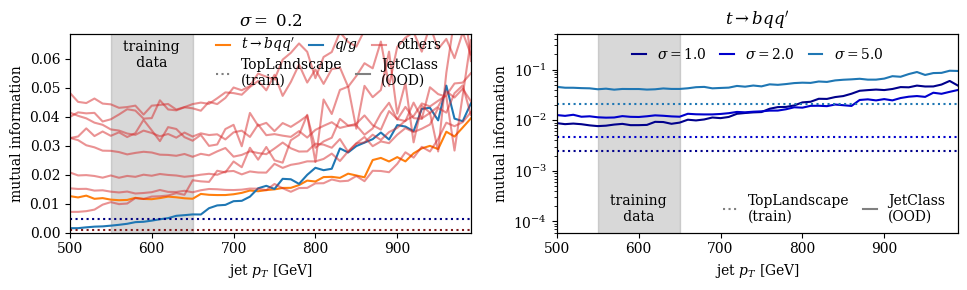

In [11]:
### plotting mutual information and dependence on sigma ###

from scipy.special import softmax
fig_OOD, ax_OOD = plt.subplots(1,2, figsize = (10,3))

x = np.arange(500,1010,10)
sigma = 2.0

top_color = (0, 0, 0.5)
qcd_color = (0.5, 0.1, 0.1)

path_tmp = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'

for i_ds, data_str in enumerate(data_strs):
    _, _, _, jet_pt, _, _, mutual_info = get_preds_OOD(path_tmp, data_str)
        
    mutual_info = np.nan_to_num(mutual_info)
    mutual_info_mean, mutual_info_min, mutual_info_max = [], [], []

    for i in range(len(x)-1):
        mask_tmp = np.bitwise_and(jet_pt<x[i+1], jet_pt>x[i])
        mutual_info_mean.append(np.median(mutual_info[mask_tmp]))
        mutual_info_min.append(np.quantile(mutual_info[mask_tmp], 0.25))
        mutual_info_max.append(np.quantile(mutual_info[mask_tmp], 0.75))

    mutual_info_mean = np.array(mutual_info_mean)
    
    if i_ds<2:
        ax_OOD[0].plot(x[:-1], mutual_info_mean, color = colors[i_ds], label = data_strs_plot[i_ds])
    elif i_ds == 2:
        ax_OOD[0].plot(x[:-1], mutual_info_mean, color = colors[i_ds], label = data_strs_plot[i_ds], alpha =.5)
        #ax_OOD[0].fill_between(x[:-1], mutual_info_min, mutual_info_max, color = qcd_color if data_str == 'ZJetsToNuNu' else top_color, alpha =0.3)
    else:
        ax_OOD[0].plot(x[:-1], mutual_info_mean, color = colors[2], alpha = 0.5)

mutual_info_cms = np.nan_to_num(np.load(path_tmp + 'mutual_info.npy'))
labels_cms = np.load(path_tmp + 'labels.npy')

for l_id in [0,1]:
    mask_tmp = labels_cms == l_id   
    mutual_info_mean = np.median(mutual_info_cms[mask_tmp])
    mutual_info_min = np.quantile(mutual_info_cms[mask_tmp], 0.25)
    mutual_info_max = np.quantile(mutual_info_cms[mask_tmp], 0.75)
    
    print(mutual_info_mean)
    ax_OOD[0].hlines(mutual_info_mean, 500 ,1000, color = qcd_color if l_id == 1 else top_color, linestyle = ':')
    #ax_OOD[0].fill_between([500,1000], mutual_info_min, mutual_info_max, color =  qcd_color if l_id == 1 else top_color, alpha =0.3)

ax_OOD[0].fill_between(np.array([550,650]), 0., 1, color = 'grey', alpha =0.3)
ax_OOD[0].text(565, 0.057, 'training \n   data')

#ax_OOD[0].text(505, 0.008, 'TopLandscape  ', ha = 'left')
#ax_OOD[0].text(505, 0.037, 'JetClass  ', ha = 'left')

ax_OOD[0].legend(loc = (0.35, 0.87), frameon = False, ncols = 3, handlelength = 1.0,  columnspacing = 1.0)
ax_OOD[0].set_ylim(-0,0.0685)
ax_OOD[0].set_xlim(500.,990)

ax_OOD[0].set_title(r'$\sigma =$' +' 0.2')
ax_OOD[0].set_ylabel('mutual information')
ax_OOD[0].set_xlabel(r'jet $p_T$ [GeV]')

ax2 = ax_OOD[0].twinx()
ax2.get_yaxis().set_visible(False)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', lw=1.5, ls = ':'),
                Line2D([0], [0], color='grey', lw=1.5, ls = '-')]

ax2.legend(custom_lines, ['TopLandscape\n(train)', 'JetClass\n(OOD)'], frameon = False, loc = (0.35,0.7), handlelength = 1, ncol = 2, columnspacing = 1.)

########################################################################################################################################################################
########################################################################################################################################################################

calc = False

lr = 1e-3
min_lr = 1e-6
lr_decay = 1# 0.998 # 0.995
temp = 1.
sigmas = [1.0, 2.0, 5.0]
top_colors = ['darkblue','mediumblue','C0','lightblue']
qcd_colors = ['saddlebrown', 'chocolate', 'C1', 'orange']
sigma_adam_dir_denom = 100
betas_adam = (0.99, 0.99)
optim_str = 'Adam'
optim_str += f'betas{betas_adam}'

n_epochs = 50
n_samples = 10
data_strs = ['TTBar']
data_strs_plot = [r'$t \rightarrow b q q^\prime$']

sigma_adam_dir =  sum(p.numel() for p in model_MCMC.parameters())/sigma_adam_dir_denom

for i_sigma,sigma in enumerate(sigmas):
    path_tmp = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'
    print(path_tmp)
    
    if calc:
        calculate_preds_OOD(model, project, path_tmp, data_strs,  n_epochs = 50, n_samples = 10)

    x = np.arange(500,1010,10)
    for i_ds, data_str in enumerate(data_strs):
        _, _, _, jet_pt, _, _, mutual_info = get_preds_OOD(path_tmp, data_str)

        mutual_info = np.nan_to_num(mutual_info)
        mutual_info_mean, mutual_info_min, mutual_info_max = [], [], []

        for i in range(len(x)-1):
            mask_tmp = np.bitwise_and(jet_pt<x[i+1], jet_pt>x[i])
            mutual_info_mean.append(np.median(mutual_info[mask_tmp]))
            mutual_info_min.append(np.quantile(mutual_info[mask_tmp], 0.25))
            mutual_info_max.append(np.quantile(mutual_info[mask_tmp], 0.75))

        mutual_info_mean = np.array(mutual_info_mean)
    
        ax_OOD[1].plot(x[:-1], mutual_info_mean, color = qcd_colors[i_sigma] if data_str == 'ZJetsToNuNu' else top_colors[i_sigma], label = r'$\sigma = $' + f'{sigma}')
        #ax_OOD2[i_ds].fill_between(x[:-1], mutual_info_min, mutual_info_max, color = qcd_colors[i_sigma] if data_str == 'ZJetsToNuNu' else top_colors[i_sigma], alpha =0.3)
        
    mutual_info_cms = np.load(path_tmp + 'mutual_info.npy')
    labels_cms = np.load(path_tmp + 'labels.npy')

    for l_id in [0]:
        mask_tmp = labels_cms == l_id   
        mutual_info_mean = np.median(mutual_info_cms[mask_tmp])
        mutual_info_min = np.quantile(mutual_info_cms[mask_tmp], 0.25)
        mutual_info_max = np.quantile(mutual_info_cms[mask_tmp], 0.75)

        ax_OOD[1].hlines(mutual_info_mean, 500 ,1000, color = qcd_colors[i_sigma] if l_id == 1 else top_colors[i_sigma], linestyle = ':')
        #ax_OOD2[int(l_id==0)].fill_between([500,1000], mutual_info_min, mutual_info_max, color = qcd_colors[i_sigma] if l_id == 1 else top_colors[i_sigma], alpha =0.3)

for i_a,a in enumerate([ax_OOD[1]]):
    a.fill_between(np.array([550,650]), 0., 1, color = 'grey', alpha =0.3)
    a.text(565, 1e-4, 'training \n   data')

    a.set_ylim(6e-5,0.5)
    a.set_xlim(500.,990)
    a.set_yscale('log')
    a.set_title(data_strs_plot[i_a])

    a.legend(loc = 'upper center', frameon = False, handlelength = 1, ncol = 4, columnspacing = 1.)

ax2 = ax_OOD[1].twinx()
ax2.get_yaxis().set_visible(False)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', lw=1.5, ls = ':'),
                Line2D([0], [0], color='grey', lw=1.5, ls = '-')]

ax2.legend(custom_lines, ['TopLandscape\n(train)', 'JetClass\n(OOD)'], frameon = False, loc = (0.4,0.017), handlelength = 1, ncol = 2, columnspacing = 1.)

# ax_OOD2[0].text(990, 5.5e-4, 'TopLandscape  ', ha = 'right')
# ax_OOD2[0].text(990, 0.007, 'JetClass  ', ha = 'right')

#ax_OOD[1].text(990, 2.5e-4, 'TopLandscape  ', ha = 'right')
#ax_OOD[1].text(990, 0.04, 'JetClass  ', ha = 'right')


ax_OOD[1].set_ylabel('mutual information')
ax_OOD[1].set_xlabel(r'jet $p_T$ [GeV]')

fig_OOD.tight_layout()
#fig_OOD.subplots_adjust(wspace=0.05)
#fig_OOD.savefig('./figs/05_OOD.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


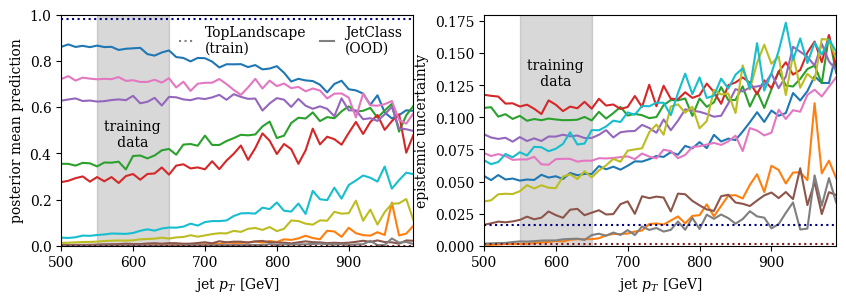

In [44]:
### plotting posterior mean and sigma ###

fig_OOD, ax_OOD = plt.subplots(1,2, figsize = (10,3))

x = np.arange(500,1010,10)
sigma = 2.0

top_color = (0, 0, 0.5)
qcd_color = (0.5, 0.1, 0.1)

min_plot_quant = 0.25
max_plot_quant = 0.75

epis_std = False
min_epis_quant = 0.25
max_epis_quant = 0.75

data_strs = ['TTBar', 'ZJetsToNuNu', 'HToBB', 'HToCC', 'HToGG', 'HToWW2Q1L', 'HToWW4Q', 'TTBarLep', 'WToQQ', 'ZToQQ']
data_strs_plot = [r'$t \rightarrow b q q^\prime$', r'$q/g$', 'others']
                #   r'$H \rightarrow b \bar{b}$', r'$H \rightarrow c \bar{c}$', r'$H \rightarrow g \bar{g}$', 
                #  r'$H \rightarrow l \nu q q^\prime$', r'$H \rightarrow 4q$', r'$t \rightarrow b l \nu$', 
                #  r'$W \rightarrow l \nu q q^\prime$', r'$Z \rightarrow q \bar{q}$'
                #  ]
                
                
#'HToWW2Q1L' and 'TTBarLep' are the only ones containing leptons and are classified as "more qcd like as qcd"

colors = ['C0', 'C1'] + [f'C{i}' for i in range(2,10)]
                
path_tmp = model_path + f'/ParticleNet_{optim_str}MCMC_lr{lr}_lrdecay{lr_decay}_temp{temp}_sigma{sigma}_sigmaadam{sigma_adam_dir}_sigmafactor{sigma_factor}/'

for i_ds, data_str in enumerate(data_strs):
    logits_out = np.load(path_tmp + data_str + f'/logits_out_{data_str}.npy')
    jet_pt = np.load(path_tmp + data_str + f'/jet_pt_{data_str}.npy')
    
    scores_out = softmax(logits_out, 1)

    if epis_std:
        pred = scores_out.mean(2)[:,0]
        epis = scores_out.std(2)[:,0]
    else:
        pred = np.median(scores_out, 2)[:,0]
        epis = np.quantile(scores_out,0.75,2)[:,0]-np.quantile(scores_out,0.25,2)[:,0]

    mean_pred, mean_epis = np.zeros((len(x)-1, 3)), np.zeros((len(x)-1, 3))
    
    for i in range(len(x)-1):
        mask_tmp = np.bitwise_and(jet_pt<x[i+1], jet_pt>x[i])
        
        mean_pred[i] = np.quantile(pred[mask_tmp], [min_plot_quant,0.5,max_plot_quant])
        mean_epis[i] = np.quantile(epis[mask_tmp], [min_plot_quant,0.5,max_plot_quant])
    
#    if i_ds<2:
    ax_OOD[0].plot(x[:-1], mean_pred[:,1], color = colors[i_ds])#, label = data_strs_plot[i_ds])
    ax_OOD[1].plot(x[:-1], mean_epis[:,1], color = colors[i_ds])#, label = data_strs_plot[i_ds])
        #ax_OOD[0].fill_between(x[:-1], mean_pred[:,0], mean_pred[:,2], alpha = 0.3, color = colors[i_ds])
        #ax_OOD[1].fill_between(x[:-1], mean_epis[:,0], mean_epis[:,2], alpha = 0.3, color = colors[i_ds])
    
#    elif i_ds == 2:
#        ax_OOD[0].plot(x[:-1], mean_pred[:,1], color = colors[i_ds], label = data_strs_plot[i_ds], alpha =.5)
#        ax_OOD[1].plot(x[:-1], mean_epis[:,1], color = colors[i_ds], label = data_strs_plot[i_ds], alpha =.5)
        #ax_OOD[0].fill_between(x[:-1], mean_pred[:,0], mean_pred[:,2], alpha = 0.3, color = colors[i_ds])
        #ax_OOD[1].fill_between(x[:-1], mean_epis[:,0], mean_epis[:,2], alpha = 0.3, color = colors[i_ds])
    
        #ax_OOD[0].fill_between(x[:-1], mutual_info_min, mutual_info_max, color = qcd_color if data_str == 'ZJetsToNuNu' else top_color, alpha =0.3)
#    else:
#        ax_OOD[0].plot(x[:-1], mean_pred[:,1], color = colors[2], alpha = 0.5)
#        ax_OOD[1].plot(x[:-1], mean_epis[:,1], color = colors[2], alpha = 0.5)
        #ax_OOD[0].fill_between(x[:-1], mean_pred[:,0], mean_pred[:,2], alpha = 0.3, color = colors[2])
        #ax_OOD[1].fill_between(x[:-1], mean_epis[:,0], mean_epis[:,2], alpha = 0.3, color = colors[2])
        
scores_out_tl = softmax(np.load(path_tmp + 'logits_out.npy'), 1)
labels_tl = np.load(path_tmp + 'labels.npy')

for l_id in [0,1]:
    mask_tmp = labels_cms == l_id   
    
    if epis_std:
        pred = scores_out_tl.mean(2)[:,0]
        epis = scores_out_tl.std(2)[:,0]
    else:
        pred = np.median(scores_out_tl, 2)[:,0]
        epis = np.quantile(scores_out_tl,0.75,2)[:,0]-np.quantile(scores_out_tl,0.25,2)[:,0]
     
    mean_pred = np.quantile(pred[mask_tmp], 0.5)
    mean_epis = np.quantile(epis[mask_tmp], 0.5)
       
    ax_OOD[0].hlines(mean_pred, 500 ,1000, color = qcd_color if l_id == 1 else top_color, linestyle = ':')
    ax_OOD[1].hlines(mean_epis, 500 ,1000, color = qcd_color if l_id == 1 else top_color, linestyle = ':')

#ax_OOD[0].text(505, 0.008, 'TopLandscape  ', ha = 'left')
#ax_OOD[0].text(505, 0.037, 'JetClass  ', ha = 'left')

#ax_OOD[0].set_ylim(-0,0.0685)

for ax in ax_OOD:
    ax.set_xlim(500.,990)
    ax.set_xlabel(r'jet $p_T$ [GeV]')
    #ax.set_title(r'$\sigma =$' +' 0.2')
    ax.fill_between(np.array([550,650]), 0., 1, color = 'grey', alpha =0.3)
ax_OOD[0].text(560, 0.43, 'training \n   data')
ax_OOD[1].text(560, 0.125, 'training \n   data')

ax_OOD[0].set_ylim(0,1)
ax_OOD[1].set_ylim(0,0.18)

ax_OOD[0].set_ylabel("posterior mean prediction")
ax_OOD[1].set_ylabel("epistemic uncertainty")

#ax2 = ax_OOD[0].twinx()
#ax2.get_yaxis().set_visible(False)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', lw=1.5, ls = ':'),
                Line2D([0], [0], color='grey', lw=1.5, ls = '-')]

ax_OOD[1].legend(loc = (0.3, 0.8), frameon = False, ncols = 3, handlelength = 1.0,  columnspacing = 1.0)
ax_OOD[0].legend(custom_lines, ['TopLandscape\n(train)', 'JetClass\n(OOD)'], frameon = False, loc = (0.32,0.8), handlelength = 1, ncol = 2, columnspacing = 1.)
